In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv1D, concatenate, Dropout, Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D,GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, Nadam,SGD
from sklearn.metrics import confusion_matrix,roc_auc_score
from collections import defaultdict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_path = 'output_model_name'
input_path = '/content/drive/MyDrive/Deep Learning/data/fullset'
dropout = 0.1
learning_rate = .0001
epochs = 30
batch_size = 128

In [ ]:
PROJECT_NAMES = []

# Helper Functions

In [ ]:
def process_line(line):
  pieces = line.split(",")
  seq = pieces[1]
  label = int(pieces[2])

  proj = pieces[0][pieces[0].find("_"):].rstrip("1234567890")
  if proj not in PROJECT_NAMES:
    PROJECT_NAMES.append(proj)
  return seq, label

In [ ]:
def DNA_to_onehot(dna_line):
  options_onehot = {'A': [1,0,0,0,0],'C' :[0,1,0,0,0], 'G':[0,0,1,0,0] ,'T':[0,0,0,1,0],'N':[0,0,0,0,1]}
  onehot_data = [options_onehot[e] for e in dna_line]
  onehot_data = np.array(onehot_data)
  return onehot_data 

## Processing Input Data to create One-Hot Encodings

In [ ]:
val_seqs = []
val_labels = []
test_seqs= []
test_labels= []
train_seqs = []
train_labels = []

f = open(input_path+"_validation.csv")
for line in f:
    line = line[:-1] #remove \n
    seq, lab = process_line(line)
    val_seqs.append(DNA_to_onehot(seq))
    val_labels.append(lab)
f.close()
val_set_size = len(val_labels)

f=open(input_path+"_test.csv")
for line in f:
  line = line[:-1]
  seq,lab= process_line(line)
  test_seqs.append(DNA_to_onehot(seq))
  test_labels.append(lab)
f.close()
test_set_size = len(test_labels)

f=open(input_path+"_train.csv")
for line in f:
  line = line[:-1]
  seq,lab= process_line(line)
  train_seqs.append(DNA_to_onehot(seq))
  train_labels.append(lab)
f.close()
train_set_size = len(train_labels)
  
# nr of steps for generator when validating/testing
val_steps_per_ep = int(val_set_size/batch_size)
te_steps_per_ep = int(test_set_size/batch_size)
tr_steps_per_ep = int(train_set_size/batch_size)
  
val_seqs= np.array(val_seqs)  # put to numpy format
val_labels = np.array(val_labels)  # put to numpy format
test_seqs = np.array(test_seqs)  # put to numpy format
test_labels = np.array(test_labels)  # put to numpy format
train_seqs = np.array(train_seqs)
train_labels = np.array(train_labels)

## Dimer and Trime Count Helper Function

In [ ]:
def get_nucleotide_index(arr):
  if arr[0] == 1:
    return 0
  elif arr[1] == 1:
    return 1
  elif arr[2] == 1:
    return 2
  elif arr[3] == 1:
    return 3
  else:
    return -1

def one_hot_dimer_trimers(arr):
  out = np.zeros(4 * 4 + 4*4*4)
  seq = [get_nucleotide_index(a) for a in arr]
  for n1, n2, n3 in zip(seq[0:], seq[1:], seq[2:]):
    if n1 == -1 or n2 == -1:
      continue
    out[n1 + n2 * 4] += 1
    if n3 == -1:
      continue
    out[n1 + n2 * 4 + n3 * 16] += 1
  return out
  
dummy = one_hot_dimer_trimers(train_seqs[0])

dt_train = np.array([one_hot_dimer_trimers(x) for x in train_seqs])
dt_val = np.array([one_hot_dimer_trimers(x) for x in val_seqs])

# ANN
This is the model that uses the dimer/timer count as its input.

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
fc_layer1 (Dense)            (None, 600)               48600     
_________________________________________________________________
fc_layer2 (Dense)            (None, 300)               180300    
_________________________________________________________________
fc_layer3 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 259,101
Trainable params: 259,101
Non-trainable params: 0
_________________________________________________________________


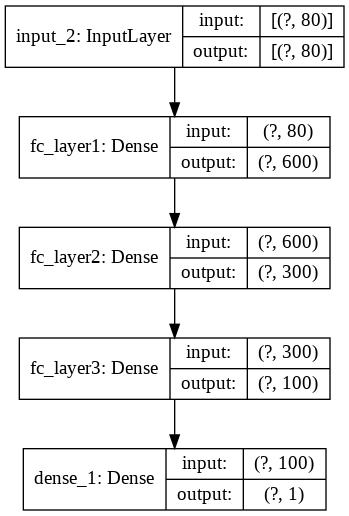

In [ ]:
inputs = Input(shape=(80))
fc_layer1 = Dense(600, activation="relu", name="fc_layer1")(inputs)
fc_layer2 = Dense(300, activation="relu", name="fc_layer2")(fc_layer1)
fc_layer3 = Dense(100, activation="relu", name="fc_layer3")(fc_layer2)
final = Dense(1,activation="sigmoid")(fc_layer3)
small_model = Model(inputs, final)
small_model.compile(optimizer = Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
small_model.summary()
tf.keras.utils.plot_model(small_model, show_shapes=True)

In [ ]:
small_model.fit(x=dt_train, y=train_labels, batch_size=batch_size, epochs=epochs, validation_data=(dt_val, val_labels), steps_per_epoch=tr_steps_per_ep, verbose=2)

Epoch 1/30
1650/1650 - 8s - loss: 0.0893 - accuracy: 0.9790 - precision_1: 0.6000 - recall_1: 0.0249 - val_loss: 0.0783 - val_accuracy: 0.9805 - val_precision_1: 0.8125 - val_recall_1: 0.0487
Epoch 2/30
1650/1650 - 8s - loss: 0.0804 - accuracy: 0.9798 - precision_1: 0.7494 - recall_1: 0.0649 - val_loss: 0.0774 - val_accuracy: 0.9809 - val_precision_1: 0.8718 - val_recall_1: 0.0637
Epoch 3/30
1650/1650 - 7s - loss: 0.0766 - accuracy: 0.9804 - precision_1: 0.8007 - recall_1: 0.0981 - val_loss: 0.0748 - val_accuracy: 0.9812 - val_precision_1: 0.6832 - val_recall_1: 0.1292
Epoch 4/30
1650/1650 - 7s - loss: 0.0737 - accuracy: 0.9808 - precision_1: 0.7914 - recall_1: 0.1233 - val_loss: 0.0731 - val_accuracy: 0.9813 - val_precision_1: 0.8197 - val_recall_1: 0.0936
Epoch 5/30
1650/1650 - 7s - loss: 0.0717 - accuracy: 0.9813 - precision_1: 0.8197 - recall_1: 0.1475 - val_loss: 0.0721 - val_accuracy: 0.9816 - val_precision_1: 0.8333 - val_recall_1: 0.1124
Epoch 6/30
1650/1650 - 7s - loss: 0.0696

# CNN-Based Model

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 5)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 290, 400)          22400     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 280, 1200)         5281200   
_________________________________________________________________
global_max_pooling1d (Global (None, 1200)              0         
_________________________________________________________________
fc_layer1 (Dense)            (None, 600)               720600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 601       
Total params: 6,024,801
Trainable params: 6,024,801
Non-trainable params: 0
____________________________________________

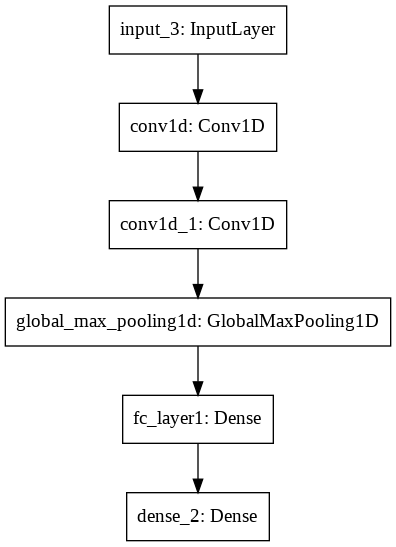

In [ ]:
inputs = Input(shape=(300,5))

first_freq = Conv1D(400,11, activation="relu")(inputs)
s_freq = Conv1D(1200,11, activation="relu")(first_freq)
freq_pooling = GlobalMaxPooling1D()(s_freq)
fc_layer1 = Dense(600, activation="relu", name="fc_layer1")(freq_pooling)
final = Dense(1,activation="sigmoid")(fc_layer1)

model = Model(inputs, final)

model.compile(optimizer = Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
model.fit(x=train_seqs, y=train_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_seqs, val_labels), steps_per_epoch=tr_steps_per_ep, verbose=2)


Epoch 1/30
1650/1650 - 178s - loss: 0.0993 - accuracy: 0.9783 - precision_2: 0.0177 - recall_2: 4.4783e-04 - val_loss: 0.0929 - val_accuracy: 0.9798 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/30
1650/1650 - 177s - loss: 0.0829 - accuracy: 0.9789 - precision_2: 0.6400 - recall_2: 0.0072 - val_loss: 0.0791 - val_accuracy: 0.9800 - val_precision_2: 0.8889 - val_recall_2: 0.0150
Epoch 3/30
1650/1650 - 177s - loss: 0.0673 - accuracy: 0.9812 - precision_2: 0.8315 - recall_2: 0.1370 - val_loss: 0.0721 - val_accuracy: 0.9821 - val_precision_2: 0.6918 - val_recall_2: 0.2060
Epoch 4/30
1650/1650 - 177s - loss: 0.0525 - accuracy: 0.9849 - precision_2: 0.8760 - recall_2: 0.3341 - val_loss: 0.0690 - val_accuracy: 0.9833 - val_precision_2: 0.8917 - val_recall_2: 0.2004
Epoch 5/30
1650/1650 - 177s - loss: 0.0381 - accuracy: 0.9885 - precision_2: 0.9134 - recall_2: 0.5057 - val_loss: 0.0752 - val_accuracy: 0.9815 - val_precision_2: 0.5603 - val_recall_2: 0.3914
Epoch 6/30
1650/16

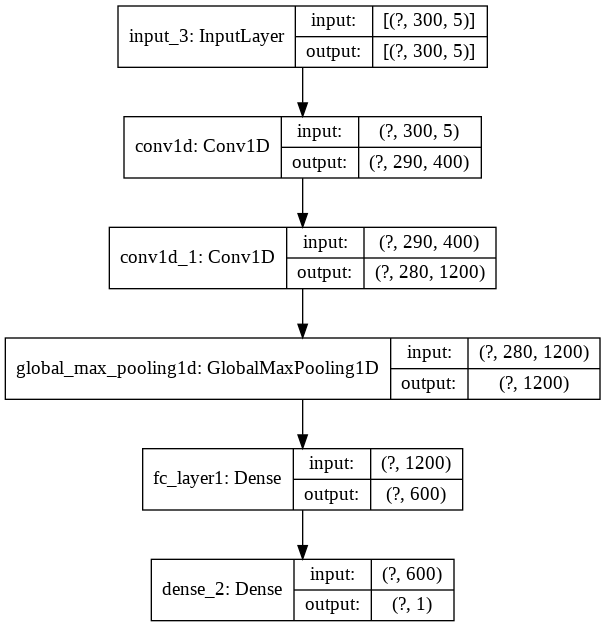

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)